In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        
#                         for i in range(len(label)):
#                             if label[i] == 'NA':
#                                 label[i] = 'O'
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence.append(('.', 'O'))
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [4]:
data_list = read_data('../data/input/output_pr/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

print len(data_list)

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words)
print n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print n_tags

[('This', 'O'), ('mutant', 'O'), ('carries', 'O'), ('a', 'O'), ('spontaneous', 'O'), ('deletion', 'O'), ('in', 'O'), ('the', 'O'), ('mouse', 'O'), ('ortholog', 'O'), ('of', 'O'), ('NR2E3', 'PR:000011403'), ('an', 'O'), ('orphan', 'O'), ('nuclear', 'O'), ('receptor', 'O'), ('transcription', 'O'), ('factor', 'O'), ('mutated', 'O'), ('in', 'O'), ('ESCS', 'O'), ('.', 'O')]
5153
12621
546


In [5]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [6]:
max_len = 75
max_len_char = 10

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

# print word2idx['Hybrid']
# print tag2idx["O"]

In [7]:
print tag2idx

{'PR:000003199': 1, 'PR:000015706': 2, 'PR:000010246': 3, 'PR:000015394': 4, 'PR:000015393': 5, 'PR:000010249': 6, 'PR:000015399': 7, 'PR:000007232': 8, 'PR:000025662': 9, 'PR:000007924': 10, 'PR:000007928': 11, 'PR:000017370': 12, 'PR:000013057': 13, 'PR:000013056': 14, 'PR:000017387': 480, 'PR:000013058': 15, 'PR:000007234': 188, 'PR:000011441': 17, 'PR:000013672': 18, 'PR:000016579': 19, 'PR:000008680': 279, 'PR:000013829': 21, 'PR:000013820': 22, 'PR:000005257': 23, 'PR:000013947': 24, 'PR:000006592': 25, 'PR:000015305': 26, 'PR:000006606': 27, 'PR:000006607': 28, 'PR:000009064': 29, 'PR:000006608': 30, 'PR:000007241': 31, 'PR:000010242': 32, 'PR:000009365': 33, 'PR:000001856': 34, 'PR:000010875': 36, 'PR:000008260': 37, 'PR:000008610': 38, 'PR:000014615': 39, 'PR:000009218': 40, 'PR:000006506': 41, 'PR:000006853': 42, 'PR:000006852': 43, 'PR:000006855': 44, 'PR:000006854': 45, 'PR:000006857': 46, 'PR:000006856': 47, 'PR:000010213': 475, 'PR:000010873': 48, 'PR:000003457': 49, 'PR:

In [8]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [10]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

95


In [11]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [12]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [13]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [14]:
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [15]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [16]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=100,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(GRU(units=100, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(GRU(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

In [17]:
from keras.optimizers import RMSprop

rmsopt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [18]:
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 100)  9700        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 100)      1262300     input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [19]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=15, validation_data=([X_word_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
                    np.array(y_te).reshape(len(y_te), max_len, 1)),
                    verbose=1)

Train on 3607 samples, validate on 1546 samples
Epoch 1/15
3607/3607 [==============================] - 32s 9ms/step - loss: 0.5349 - acc: 0.9397 - val_loss: 0.2034 - val_acc: 0.9673
Epoch 2/15
3607/3607 [==============================] - 32s 9ms/step - loss: 0.1142 - acc: 0.9832 - val_loss: 0.0944 - val_acc: 0.9884
Epoch 3/15
3607/3607 [==============================] - 32s 9ms/step - loss: 0.0572 - acc: 0.9913 - val_loss: 0.0703 - val_acc: 0.9909
Epoch 4/15
3607/3607 [==============================] - 31s 9ms/step - loss: 0.0398 - acc: 0.9937 - val_loss: 0.0664 - val_acc: 0.9920
Epoch 5/15
3607/3607 [==============================] - 32s 9ms/step - loss: 0.0311 - acc: 0.9950 - val_loss: 0.0624 - val_acc: 0.9926
Epoch 6/15
3607/3607 [==============================] - 35s 10ms/step - loss: 0.0282 - acc: 0.9953 - val_loss: 0.0585 - val_acc: 0.9929
Epoch 7/15
3607/3607 [==============================] - 37s 10ms/step - loss: 0.0255 - acc: 0.9958 - val_loss: 0.0661 - val_acc: 0.9924
Epoch

In [20]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/PR_merged_CHAR_GRU_Based.tsv', sep='\t')

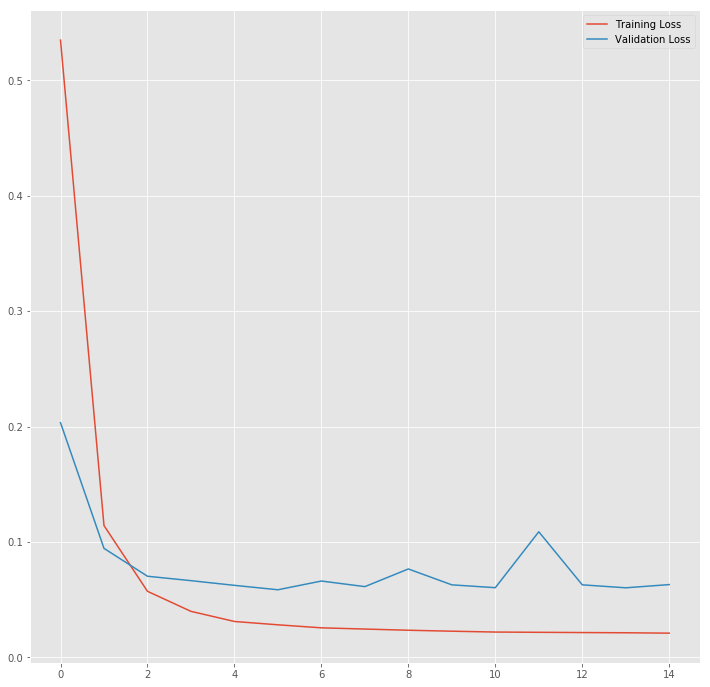

In [21]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

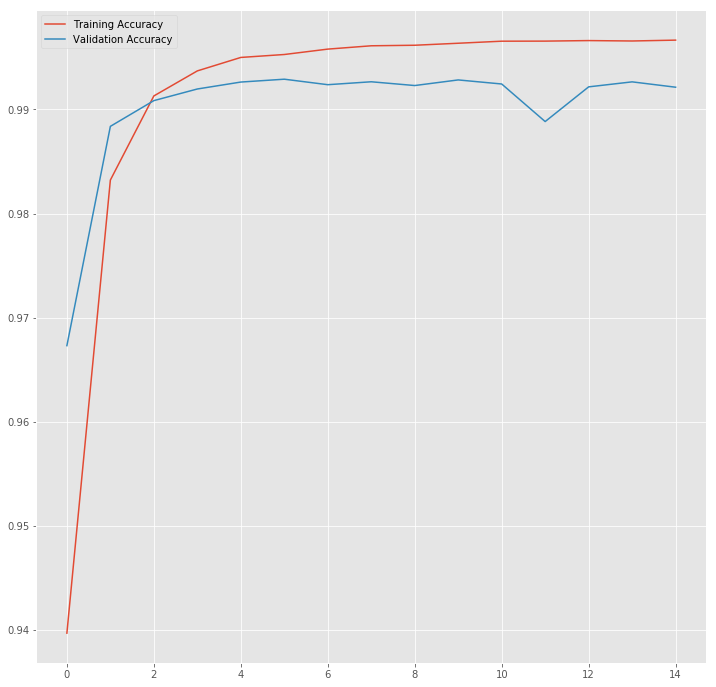

In [22]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = y_te[i]
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

print word[2]
print predicted_val[2]
print true[2]

wd = [list(map(lambda x: idx2word[x], y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]


print wd[2]
print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

[2816 7449 6794 9350 2167 7449 6721 9350 8371 8902 6794 7703 3234 8902
 6721 7703  500    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[ 0  0  0 35  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[ 0  0  0 35  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
['Solid', 'black', '4monthold', 'Sam68', 'hatched', 'black', '12monthold', 'Sam68', 'solid', 'red', '4monthold', 'Sam68\xe2\x88\x92\xe2\x88\x92', 'stippled', 

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [24]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], y_te[i], pred):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w], idx2tag[tr], idx2tag[pred]))

# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

Word           ||True ||Pred
TGCs           : O     O
pGBKT7         : O     O
tree           : O     O
insitu         : O     O
obstacles      : PR:000009279 PR:000009279
Cyto           : O     O
bioinformatic  : O     O
electrolyte    : O     O
BCAA           : O     O
erythroid      : O     O
tried          : O     O
pCRIITOPO      : O     O
revealed       : O     O
insitu         : O     O
unbranched     : O     O
rapidly        : O     O
Amyloidosis    : O     O
Cardiac        : O     O
−80          : O     O
8p2111         : O     O
sitespecific   : O     O
WNTs           : O     O
unbranched     : O     O
UTSW           : O     O
Developmental  : O     O
180            : O     O
8p2111         : O     O
Chondrogenesis : O     O
BCAA           : O     O
Developmental  : O     O
GGGAGGGAACAGAAATCCTT: O     O
much           : O     O


In [25]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [26]:
df = df[df['Word'] != 'O']

In [27]:
df.to_csv('../data/results/PR_CHAR_GRU_Based.tsv', sep='\t')

In [28]:
%run ./accuracy/src/computeSim.py ../data/results/PR_CHAR_GRU_Based.tsv ../data/validation_data/PR_AllSubsumers.tsv

Mean semantic similarity:  0.89
